In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
#import re
#from util import load_metric
from scipy.stats import spearmanr, pearsonr, zscore, rankdata, ttest_ind, ks_2samp, mannwhitneyu
import matplotlib.pyplot as plt


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', None)

## Functions

In [3]:
def read_csv(path):
    return pd.read_csv(path, sep=";", index_col=0)

In [4]:
# def find_transitions(df, var):
#     cols = [col for col in df.columns if col.startswith(var)]
#     cols.sort()
#     transitions = [tuple(col.split("_")[-1].split(":")) for col in cols]
#     return transitions

In [5]:
# Identifying a shared vocabulary
def shared_voc(df1, df2, only_core = True):
    shared_words = set(df1.index).intersection(set(df2.index))
    if only_core:
        shared_words = [w for w in shared_words if w.startswith(("A1_", "N1_", "V1_"))]
    shared_words.sort()
    return shared_words
    

In [6]:
# Identifying a shared variables
def shared_variables(df1, df2, var):
    vec1 = set([col for col in df1.columns if col.startswith(var)])
    vec2 = set([col for col in df2.columns if col.startswith(var)])
    shared_vec = list(vec1.intersection(vec2))
    shared_vec.sort()
    return shared_vec  

In [46]:
def count_only(df, df_ref, min_freq):
    df = df.copy()
    #transitions = find_transitions(df, var)
    transitions = [tuple(col.split("_")[-1].split(":")) for col in df.columns]
    var = df.columns[0].split("_")[0]
    for word in df.index:
        for ti, tj in transitions:
            f_at_ti = df_ref.loc[word][f"frq_{ti}"]
            f_at_tj = df_ref.loc[word][f"frq_{tj}"]
            if f_at_ti < min_freq or f_at_tj < min_freq:
                df.at[word, f"{var}_{ti}:{tj}"] = np.nan
    return df

In [8]:
# Find parallel vectors
def parallel_vec(df1, df2, var, only_core = True, min_freq = 5, verbose = True):
    vocabulary = shared_voc(df1, df2, only_core)
    variables  = shared_variables(df1, df2, var)
    
    # Select a sub-dataframe
    selected_df1 = df1.loc[vocabulary][variables]
    selected_df2 = df2.loc[vocabulary][variables]
    
    if min_freq != None:
        selected_df1 = count_only(selected_df1, df1, min_freq)
        selected_df2 = count_only(selected_df2, df2, min_freq)
    
    vec1 = []
    vec2 = []
    ref  = []
    for word in vocabulary:
        vec1.extend(selected_df1.loc[word][variables].tolist())
        vec2.extend(selected_df2.loc[word][variables].tolist())
        ref.extend([f"{word}_{var}" for var in variables])
    assert len(vec1) == len(vec2)
    
    if verbose:
        print(f"N step 0: {len(vocabulary)*len(variables)} (length voc x length var)")
        print(f"N step 1: {selected_df1.count().sum()}, {selected_df2.count().sum()} (min frequency only)")
    
    XY = [(x, y, w) for x, y, w in zip(vec1, vec2, ref) if not pd.isna(x) and not pd.isna(y)]
    vec1, vec2, ref = zip(*XY)
    
#     if norm != None:
#         vec1 = norm(vec1)
#         vec2 = norm(vec2)

    if verbose:
        print(f"N step 2: {len(vec1)}, {len(vec2)} (no NaN in pairs)")    
    
    return list(vec1), list(vec2), list(ref) 
    

In [9]:
def binary(vec, th):
    new_v = []
    for v in vec:
        new_v.append(int(v>th))
    return new_v

In [10]:
def cohen_d(x,y): # https://stackoverflow.com/questions/21532471/how-to-calculate-cohens-d-in-python
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

In [11]:
def find_breaks(array):
    breaks = []
    for i, lbl in enumerate(array[1:], start=1):
        this_label = lbl.split("_")[1]      # N1_globalist_...
        prev_label = array[i-1].split("_")[1]
        #print(this_label, prev_label)
        if this_label != prev_label: 
            #print(i)
            breaks.append(i)
    return breaks

In [23]:
def vis(v1, v2, ref, name_v1_as_fb=True):
    #N = range(len(v1))
    if name_v1_as_fb:
        label1 = "Flashback"
        label2 = "Familjeliv"
    else:
        label1 = "V1"
        label2 = "v2"
    
    plt.plot(ref, v1, "-b", label=label1)
    plt.plot(ref, v2, "-r", label=label2)
    for line in find_breaks(ref):
        plt.axvline(line, color="black", linestyle="dashed")
    plt.xticks(rotation=90, ha='right')
    plt.legend(loc="upper left")
    fig = plt.gcf()
    fig.set_size_inches(25, 12)
    #plt.legend(loc="upper left")
    fig.align_xlabels()
    plt.show()

In [13]:
standard_tests = [ # var, min_freq, 
    ("rch", 5),
    ("rch", 10),
    ("gch", 5),
    ("gch", 10)
]

In [14]:
def compare(df1, df2, tests=standard_tests):
    results = []
    distrib = []
    
    for measure, criterion in tests:
        d = dict()
        
        name = f"{measure}_{criterion}"
        
        d["Test-version"] = name
        
        v1, v2, ref = parallel_vec(df1, df2, measure, min_freq = criterion, verbose = False)
        
        distrib.append((name, v1, v2, ref))
        
        spearman = spearmanr(v1, v2)
        pearson  = pearsonr(v1, v2)
        ks       = ks_2samp(v1, v2)
        mw       = mannwhitneyu(v1, v2)
        ttest    = ttest_ind(v1, v2)
        
        d["Spearman's rho"]       = spearman.statistic
        d["p (spearman)"]         = spearman.pvalue
        d["Pearson's r"]          = pearson.statistic
        d["p (pearson)"]          = pearson.pvalue
        d["Kolmogorov–Smirnov D"] = ks.statistic
        d["p (KS-test)"]          = ks.pvalue
        d["Mann–Whitney U"]       = mw.statistic
        d["p (MW-test)"]          = mw.pvalue
        d["p(v1 > v2) (MW-test)"] = mw.statistic / (len(v1) * len(v2)) 
        # https://journals.sagepub.com/doi/pdf/10.1177/1536867X1201200202 
        # https://www.researchgate.net/post/How-can-I-calculate-the-effect-sizes-of-small-samples-20-for-non-parametric-tests-Wilcoxon-and-Mann-Whitney-U
        d["Student's t"]          = ttest.statistic
        d["p (t-test)"]           = ttest.pvalue
        d["Cohen's d"]            = cohen_d(v1, v2)
        
        results.append(d)
    
    results = pd.DataFrame(results)
    #results = results.set_index(['Test-version'])
    
    return results, distrib
    

## DATA

In [15]:
results_dir = Path("../../dw_results")

In [16]:
files = sorted(os.listdir(results_dir))
_ = [print(file) for file in files]

bert-v0
change_tables
fb_pol-time_bin-bert-fb_nli.csv
fb_pol-time_bin-bert-sentence-bert-swedish-cased.csv
fb_pol-time_bin-bert-sts_fbmodel.csv
fb_pol-time_bin-bert-sts_fbmodel_big_40epochs.csv
fb_pol-time_bin-radical3-full.csv
fb_pol-time_bin-radical3-restricted.csv
fb_pol-yearly-bert-fb_nli.csv
fb_pol-yearly-bert-sentence-bert-swedish-cased.csv
fb_pol-yearly-bert-sts_fbmodel.csv
fb_pol-yearly-bert-sts_fbmodel_big_40epochs.csv
fb_pol-yearly-cluster-sentence-bert-swedish-cased.csv
fb_pol-yearly-cluster-sts_fbmodel.csv
fb_pol-yearly-radical3-full.csv
fb_pol-yearly-radical3-restricted.csv
fm_smh-yearly-bert-sentence-bert-swedish-cased.csv
fm_smh-yearly-cluster-sentence-bert-swedish-cased.csv
fm_smh-yearly-radical3-full.csv
fm_smh-yearly-radical3-restricted.csv
neighbors


In [17]:
#df_yearly         = read_csv(results_dir / "fb_pol-yearly-radical3-full.csv")
df_yearly_dwt     = read_csv(results_dir / "fb_pol-yearly-radical3-restricted.csv")
df_bert_kb        = read_csv(results_dir / "fb_pol-yearly-bert-sentence-bert-swedish-cased.csv")
#df_yearly_ref     = read_csv(results_dir / "fm_smh-yearly-radical3-full.csv")
df_yearly_dwt_ref = read_csv(results_dir / "fm_smh-yearly-radical3-restricted.csv")
df_bert_kb_ref    = read_csv(results_dir / "fm_smh-yearly-bert-sentence-bert-swedish-cased.csv")
df_cluster        = read_csv(results_dir / "fb_pol-yearly-cluster-sentence-bert-swedish-cased.csv")
df_cluster_ref    = read_csv(results_dir / "fm_smh-yearly-cluster-sentence-bert-swedish-cased.csv")

## SGNS

In [25]:
res, dist = compare(df_yearly_dwt, df_yearly_dwt_ref, tests=standard_tests)

In [26]:
res.T

,0,1,2,3
Test-version,rch_5,rch_10,gch_5,gch_10
Spearman's rho,0.11679,0.11679,0.109158,0.109158
p (spearman),0.434336,0.434336,0.465154,0.465154
Pearson's r,0.050456,0.050456,0.0855422,0.0855422
p (pearson),0.736261,0.736261,0.567521,0.567521
Kolmogorov–Smirnov D,0.489362,0.489362,0.553191,0.553191
p (KS-test),1.79992e-05,1.79992e-05,5.85737e-07,5.85737e-07
Mann–Whitney U,1615,1615,1729,1729
p (MW-test),0.00011499,0.00011499,2.37443e-06,2.37443e-06
p(v1 > v2) (MW-test),0.7311,0.7311,0.782707,0.782707


RCH_5


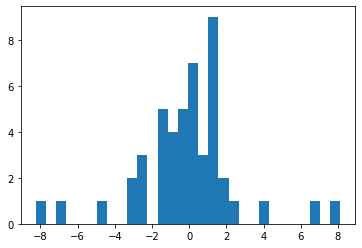

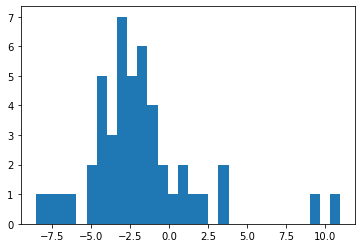

RCH_10


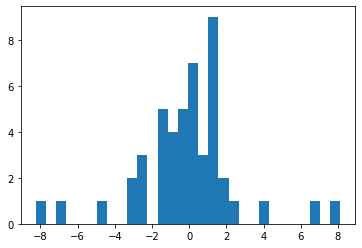

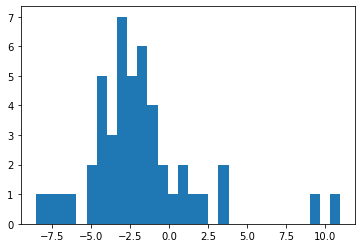

GCH_5


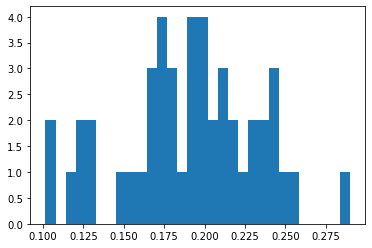

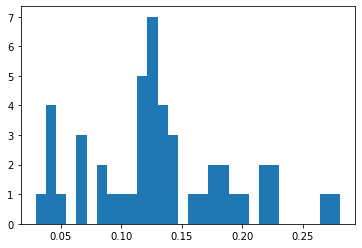

GCH_10


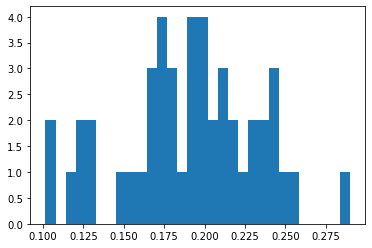

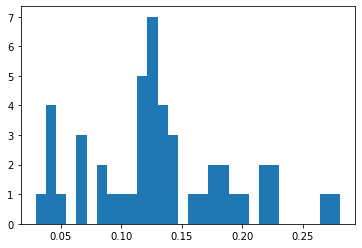

In [27]:
# (Non) Normality
for name, A, B, _ in dist:
    print(name.upper())
    plt.hist(A, bins=30)
    plt.show()
    plt.hist(B, bins=30)
    plt.show()    

RCH_5


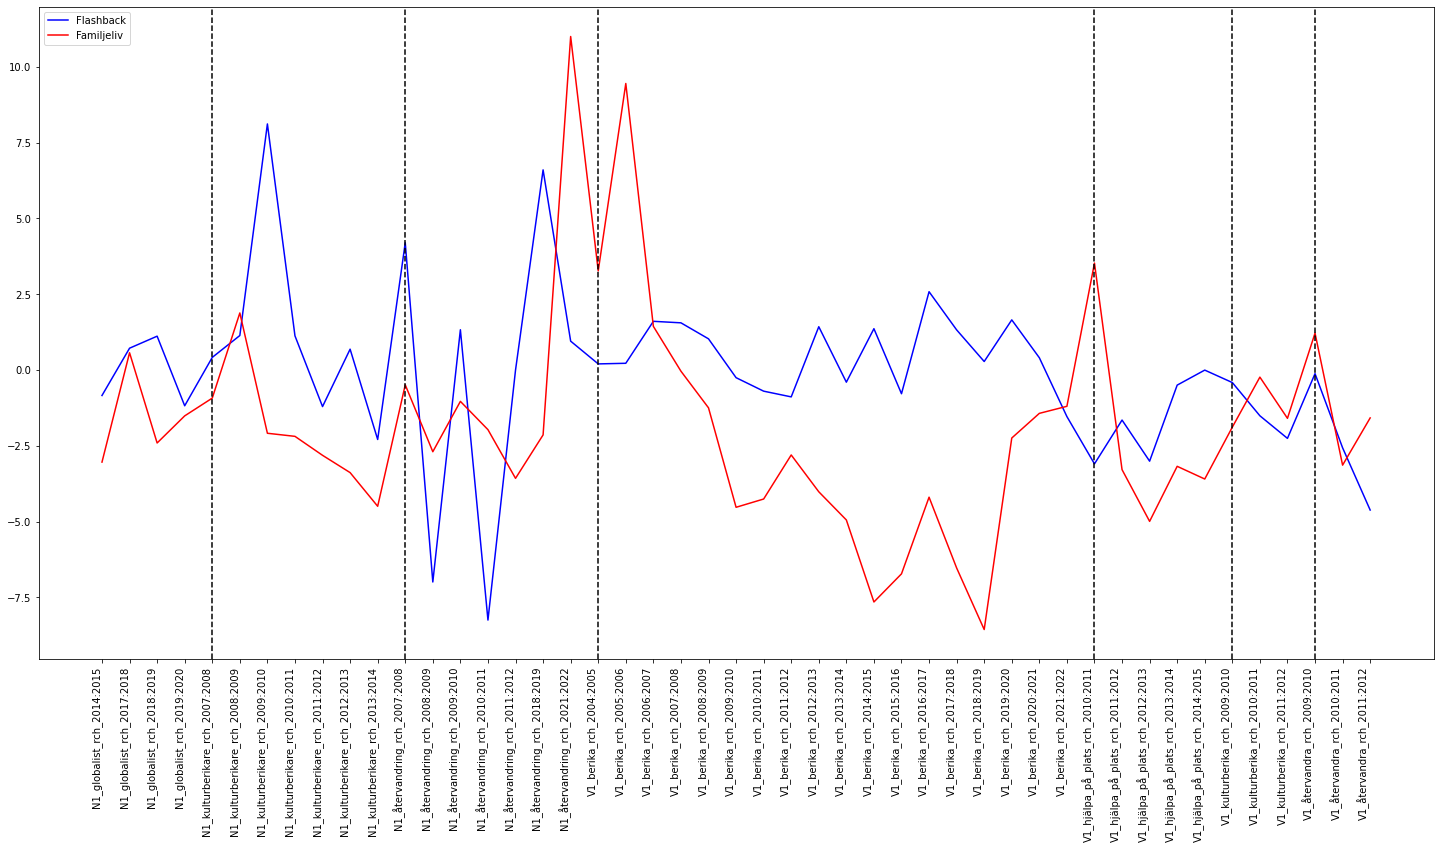

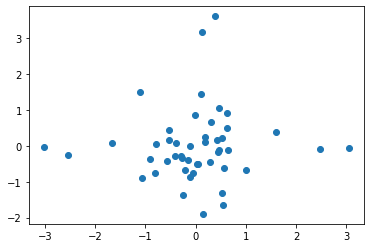

RCH_10


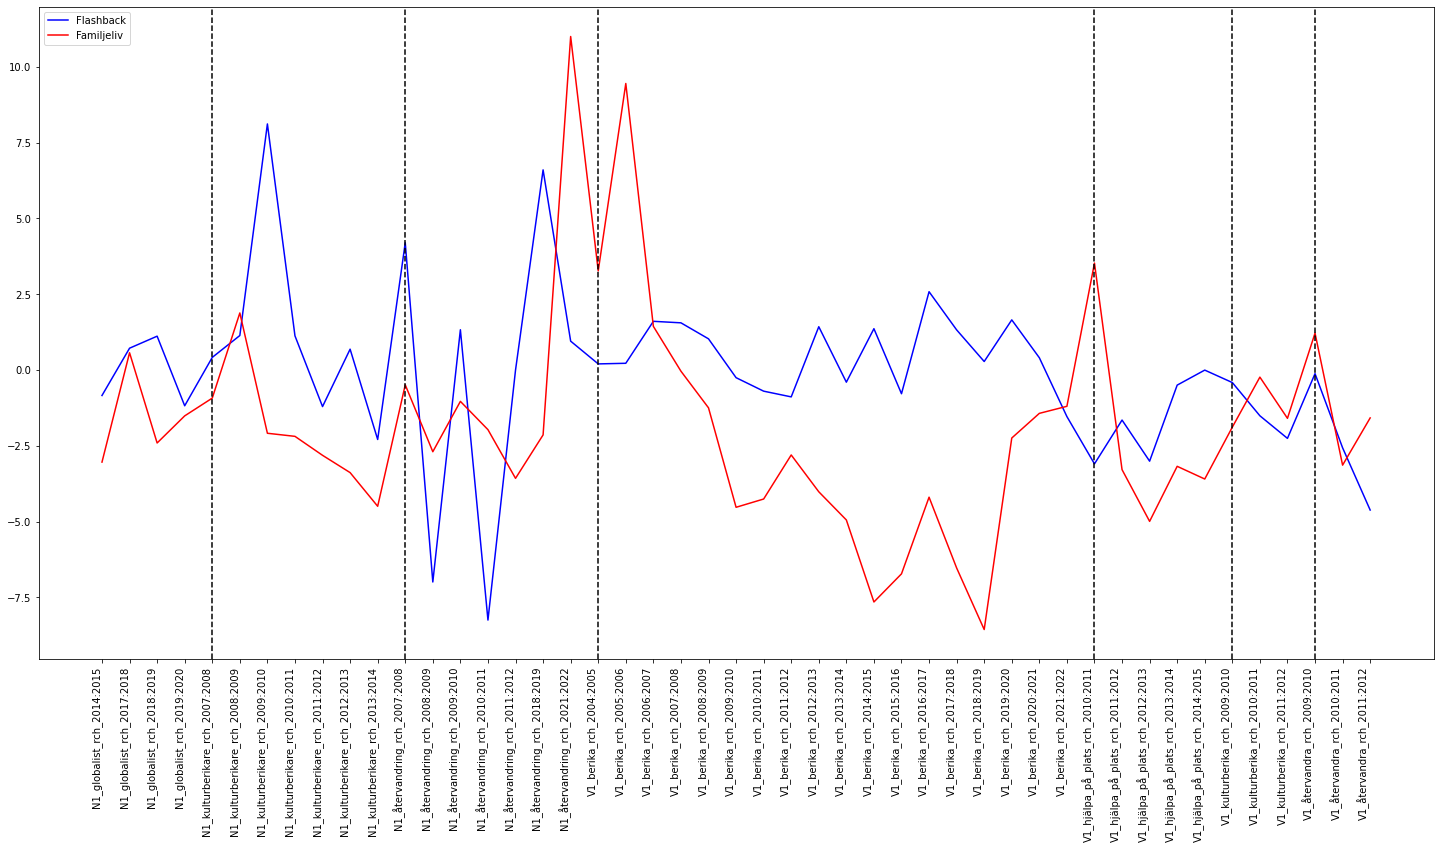

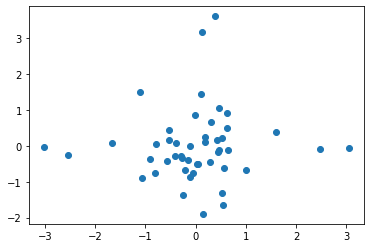

GCH_5


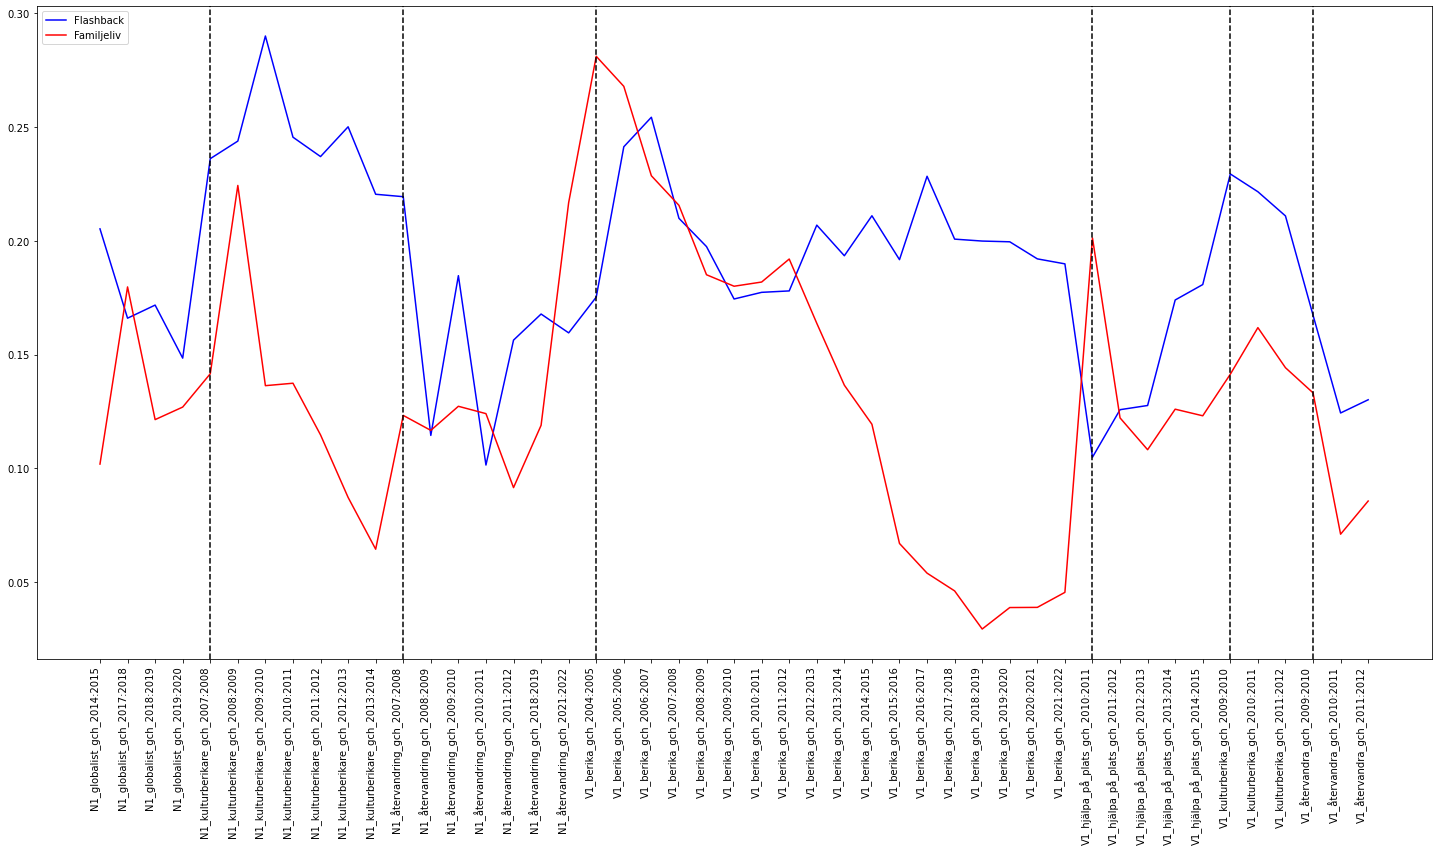

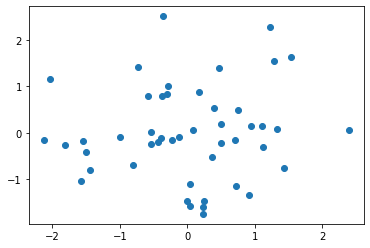

GCH_10


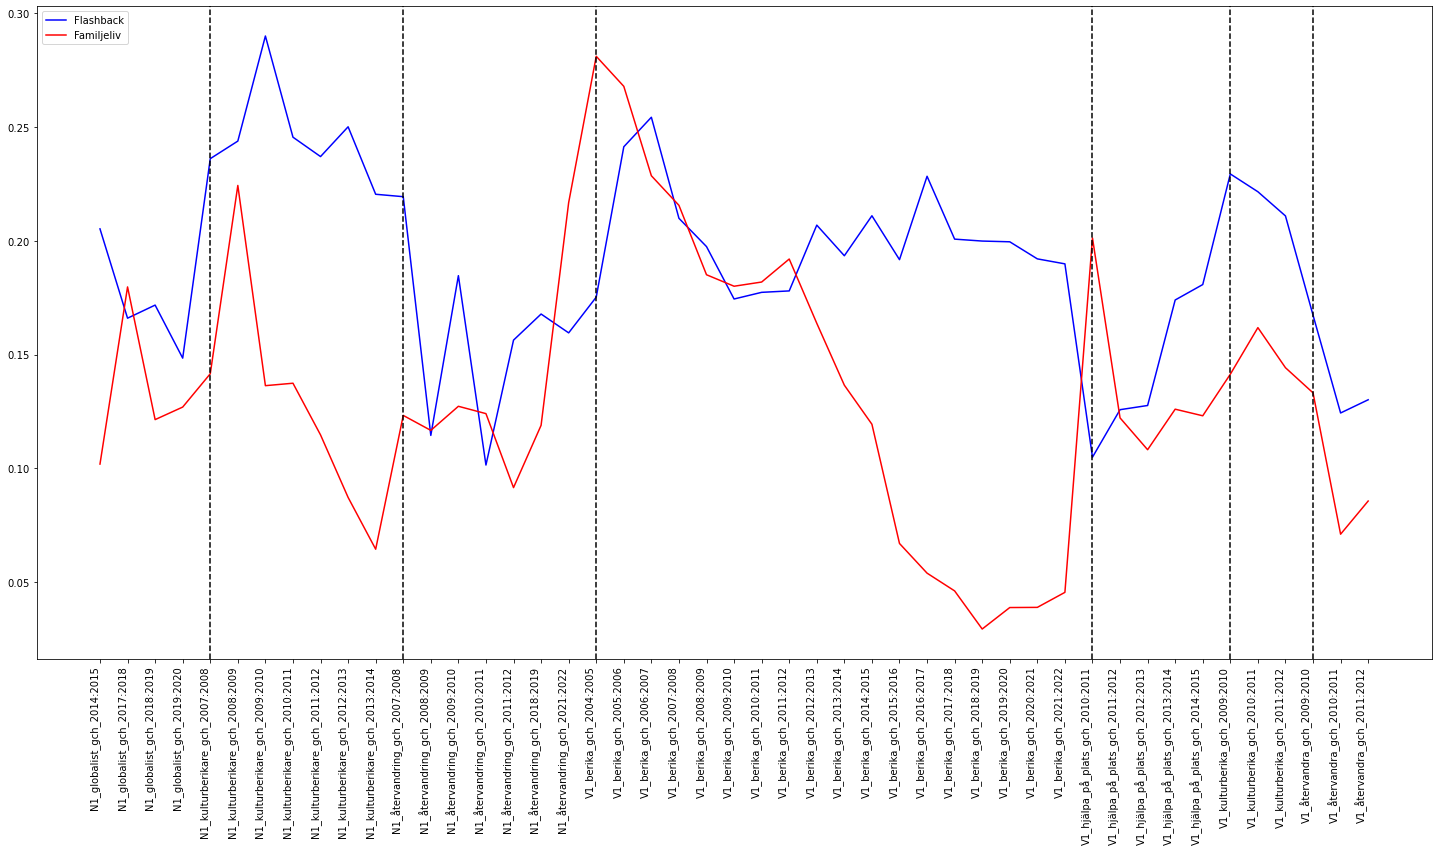

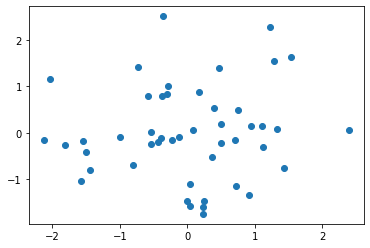

In [28]:
for name, A, B, ref in dist:
    print(name.upper())
    vis(A, B, ref)
    plt.scatter(zscore(A), zscore(B))
    plt.show()

## BERT

In [18]:
res, dist = compare(df_bert_kb, df_bert_kb_ref, tests=standard_tests)

In [19]:
res.T

,0,1,2,3
Test-version,rch_5,rch_10,gch_5,gch_10
Spearman's rho,0.249741,0.246245,0.076225,-0.0433465
p (spearman),0.0609944,0.102975,0.573055,0.777386
Pearson's r,0.0703395,0.0749682,0.029617,-0.10911
p (pearson),0.603111,0.62453,0.826886,0.475556
Kolmogorov–Smirnov D,0.245614,0.288889,0.684211,0.666667
p (KS-test),0.063929,0.0462709,5.17375e-13,8.8215e-10
Mann–Whitney U,2105,1329,250,154
p (MW-test),0.00652335,0.0107715,6.87807e-15,4.39677e-12
p(v1 > v2) (MW-test),0.647892,0.656296,0.0769468,0.0760494


RCH_5


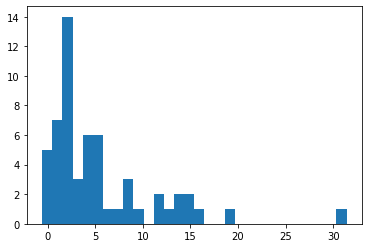

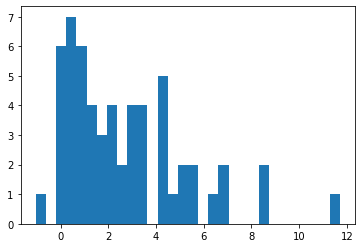

RCH_10


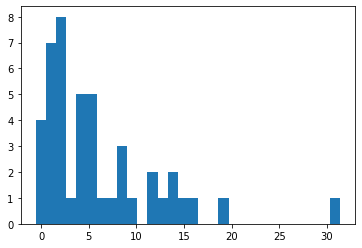

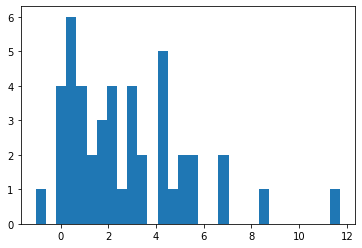

GCH_5


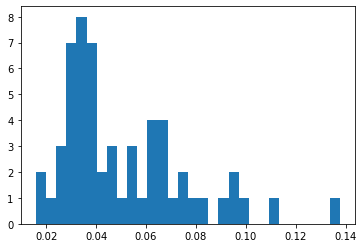

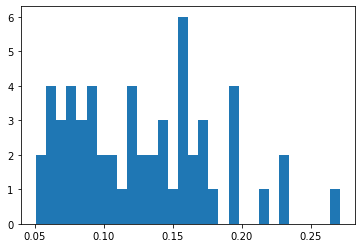

GCH_10


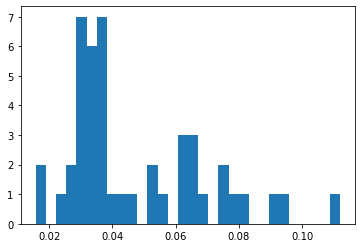

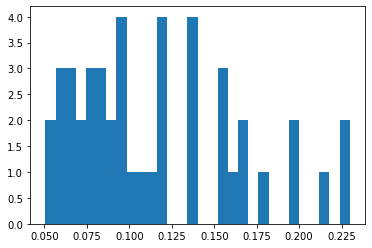

In [20]:
# (Non) Normality
for name, A, B, _ in dist:
    print(name.upper())
    plt.hist(A, bins=30)
    plt.show()
    plt.hist(B, bins=30)
    plt.show()    

RCH_5


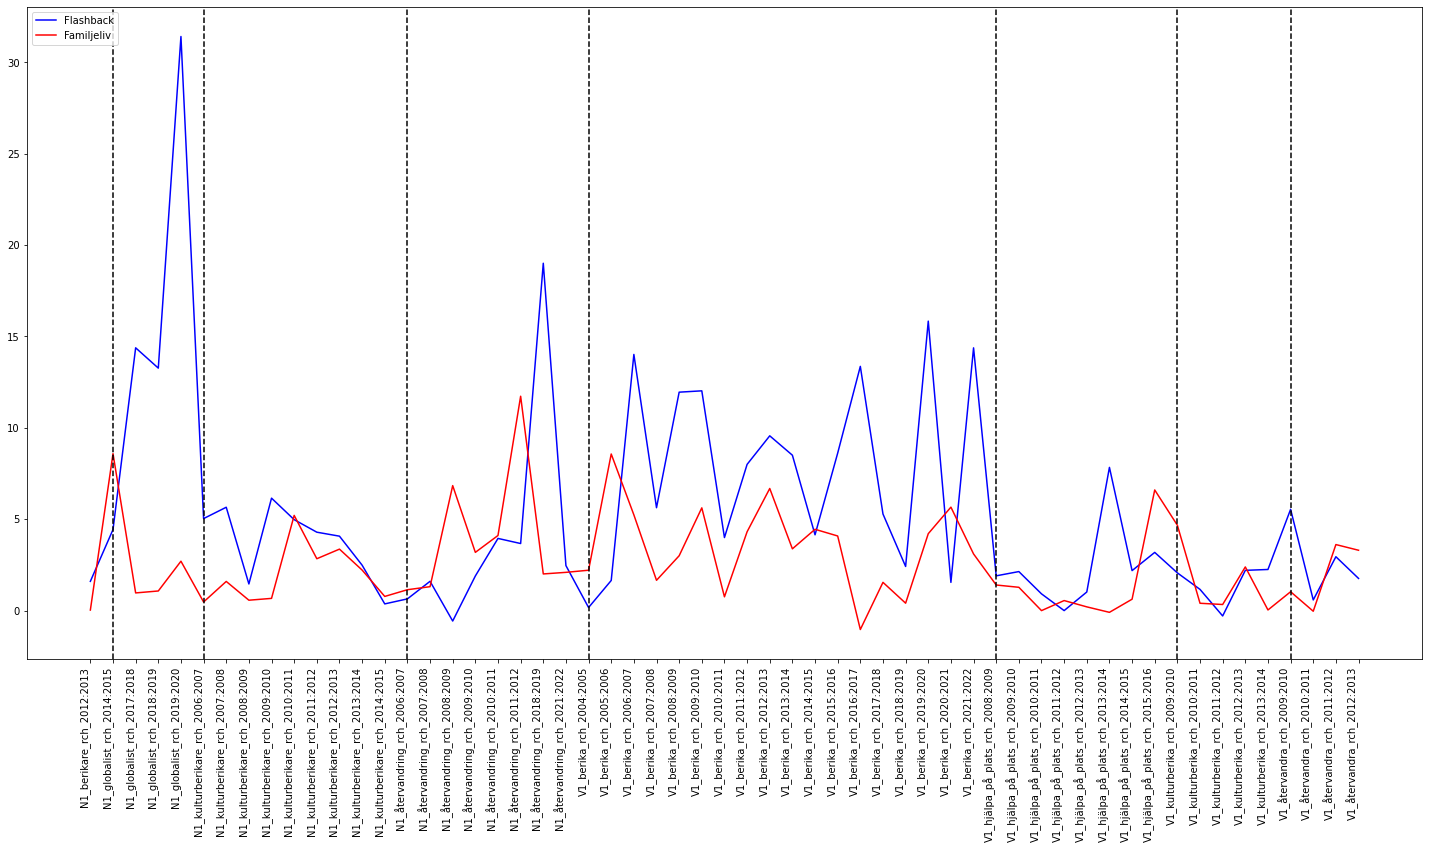

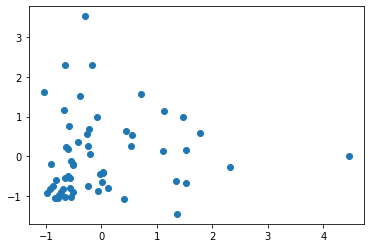

RCH_10


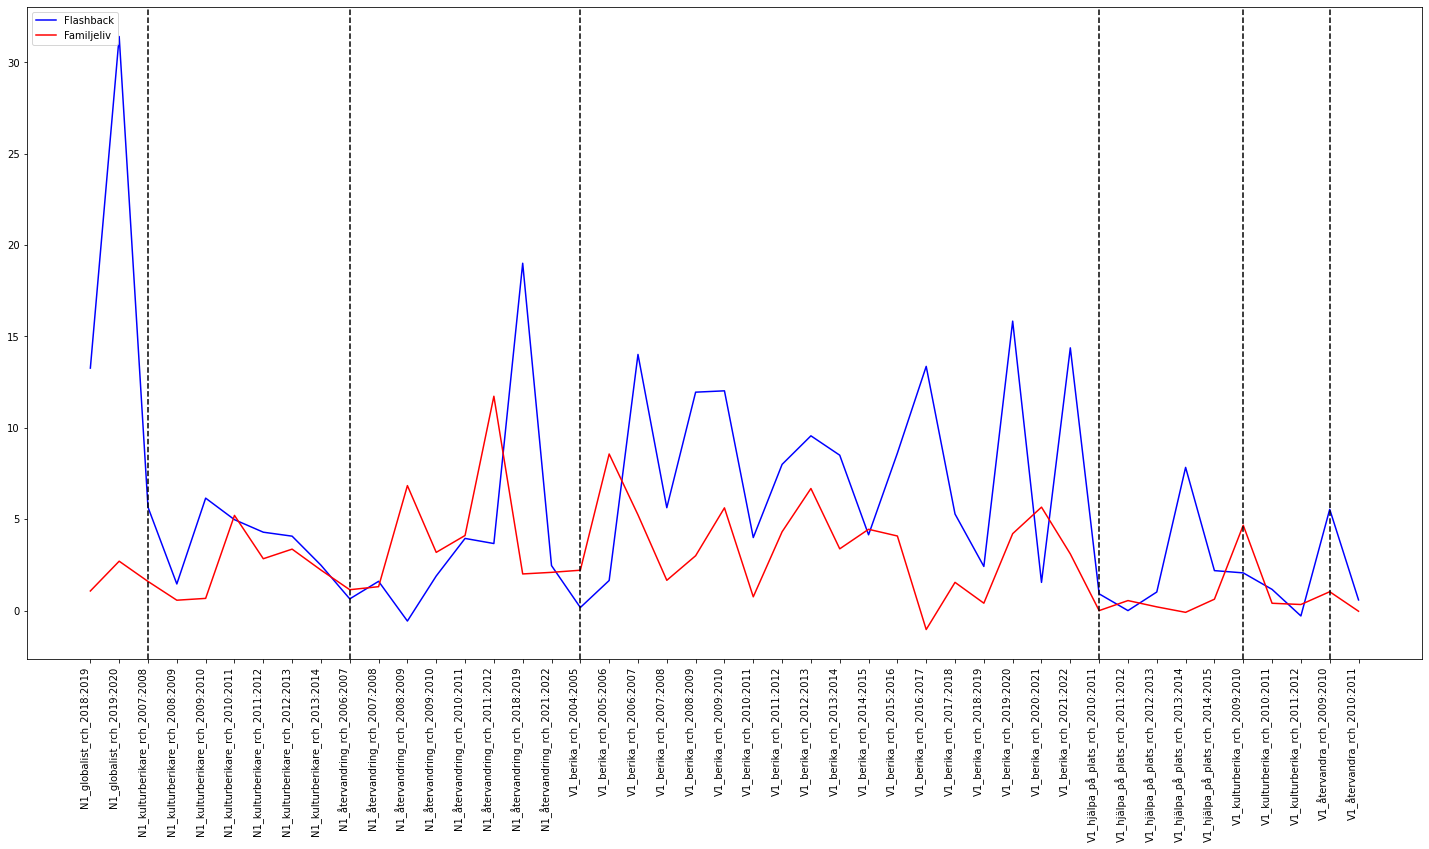

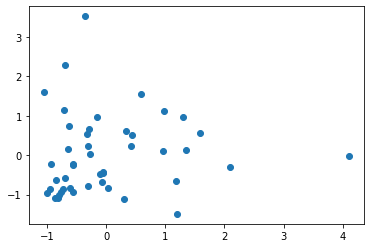

GCH_5


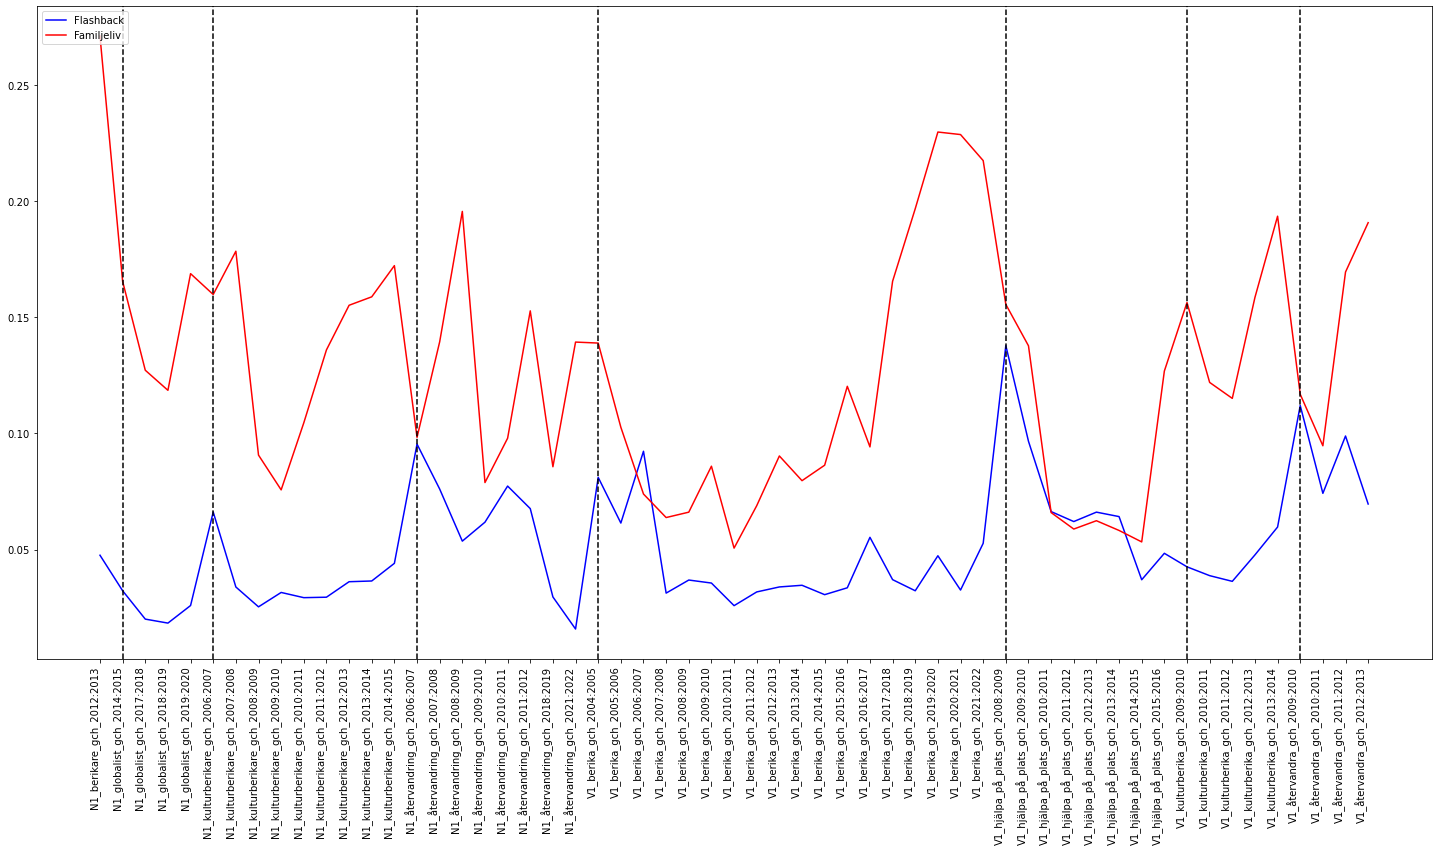

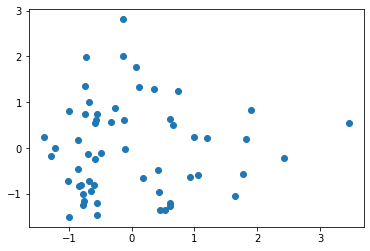

GCH_10


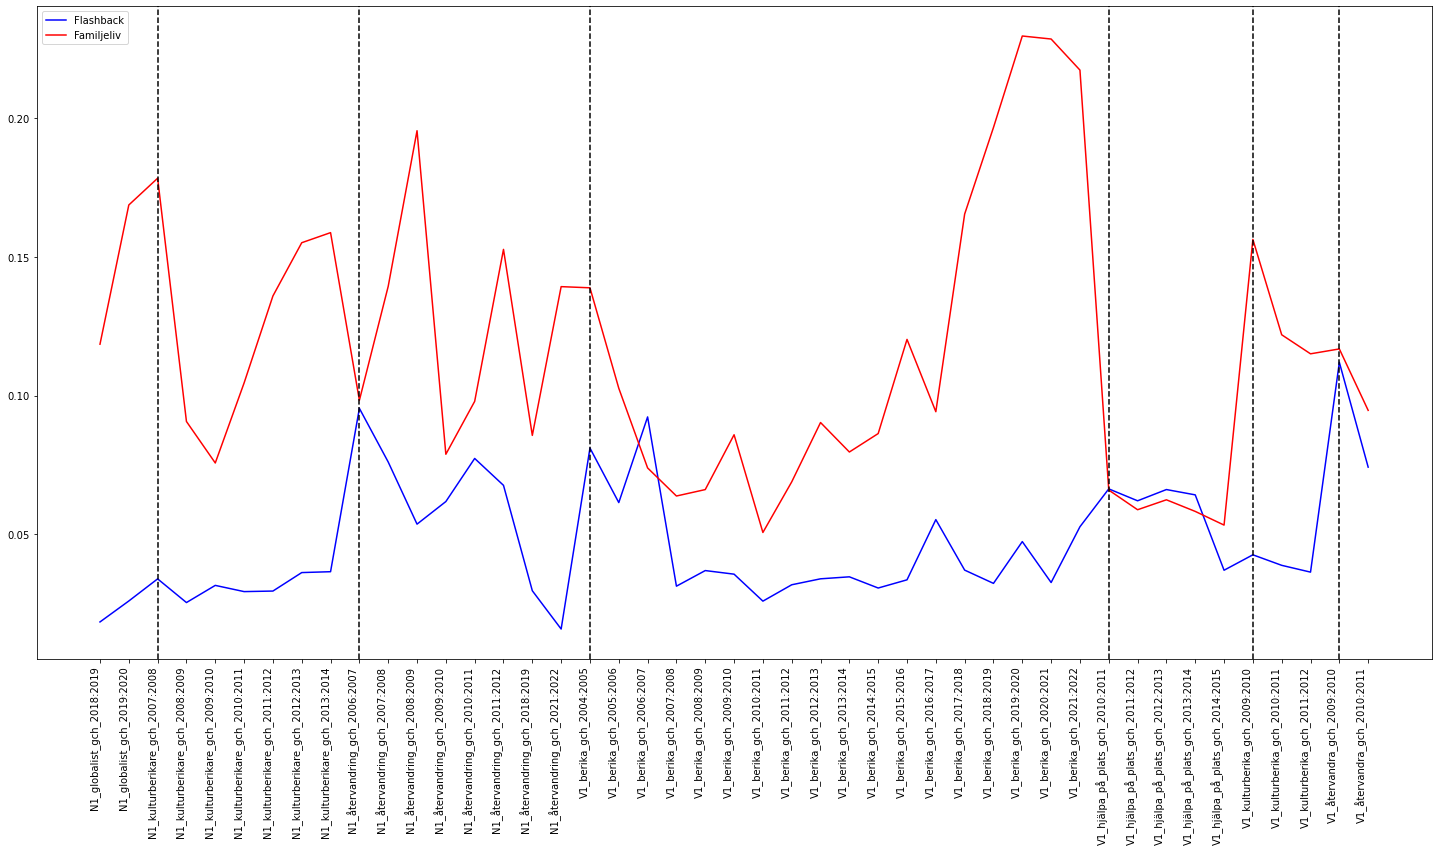

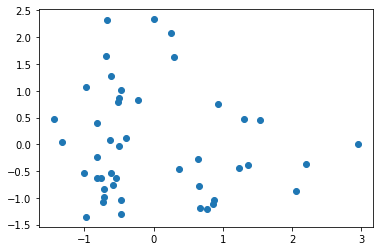

In [24]:
for name, A, B, ref in dist:
    print(name.upper())
    vis(A, B, ref)
    plt.scatter(zscore(A), zscore(B))
    plt.show()

## Clusters

In [30]:
set([col.split("_")[0] for col in df_cluster.columns if col.startswith(("km", "ac"))])

{'acs', 'acsr50', 'km15', 'km5', 'kms', 'kmsr50'}

In [51]:
cluster_tests = [ # var, min_freq, 
    ("kms", 5),
    ("kms", 10),
    ("kmsr50", 5),
    ("kmsr50", 10),
    ("km15", 30)
]

In [52]:
#df_cluster
#df_cluster_ref
res, dist = compare(df_cluster, df_cluster_ref, tests=cluster_tests)

In [53]:
res.T

,0,1,2,3,4
Test-version,kms_5,kms_10,kmsr50_5,kmsr50_10,km15_30
Spearman's rho,0.173497,0.177675,0.175099,0.175617,0.463158
p (spearman),0.101973,0.0957586,0.249955,0.254177,0.0458188
Pearson's r,0.184276,0.184498,0.169544,0.169391,0.269783
p (pearson),0.0820915,0.0834805,0.26553,0.271667,0.263997
Kolmogorov–Smirnov D,0.677778,0.674157,0.688889,0.681818,0.578947
p (KS-test),5.78752e-20,1.61836e-19,1.74109e-10,4.90083e-10,0.00276719
Mann–Whitney U,1007,1000,242,236,68
p (MW-test),3.18887e-18,7.2198e-18,5.17614e-10,1.03058e-09,0.00107619
p(v1 > v2) (MW-test),0.124321,0.126247,0.119506,0.121901,0.188366


KMS_5


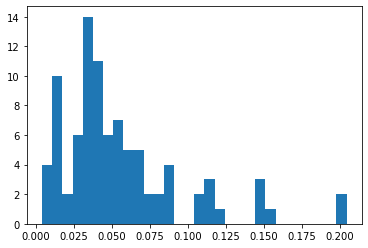

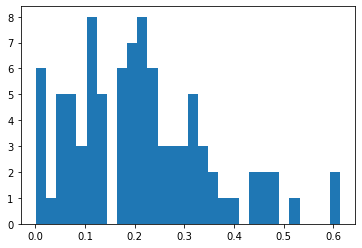

KMS_10


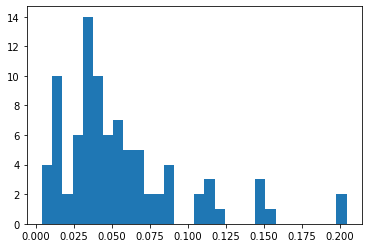

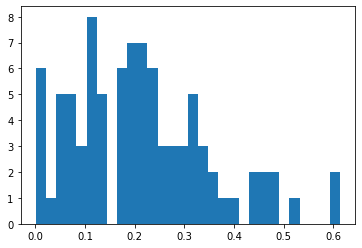

KMSR50_5


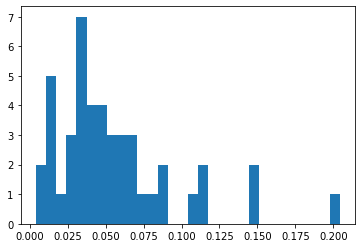

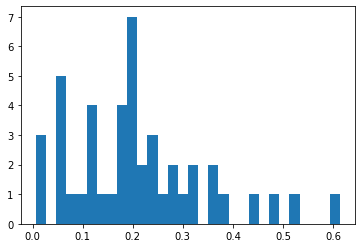

KMSR50_10


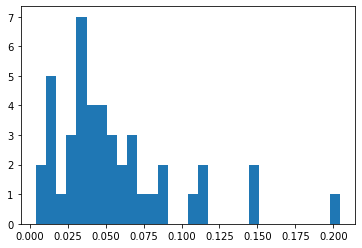

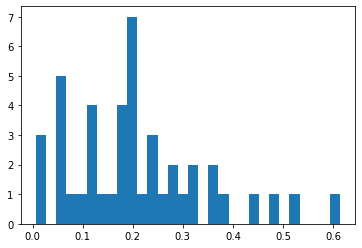

KM15_30


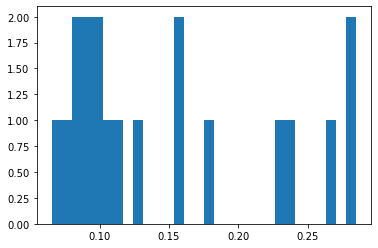

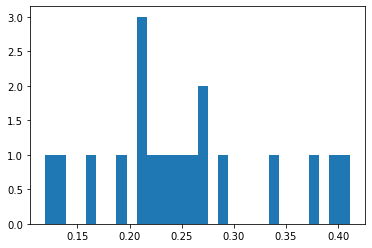

In [54]:
# (Non) Normality
for name, A, B, _ in dist:
    print(name.upper())
    plt.hist(A, bins=30)
    plt.show()
    plt.hist(B, bins=30)
    plt.show()    

KMS_5


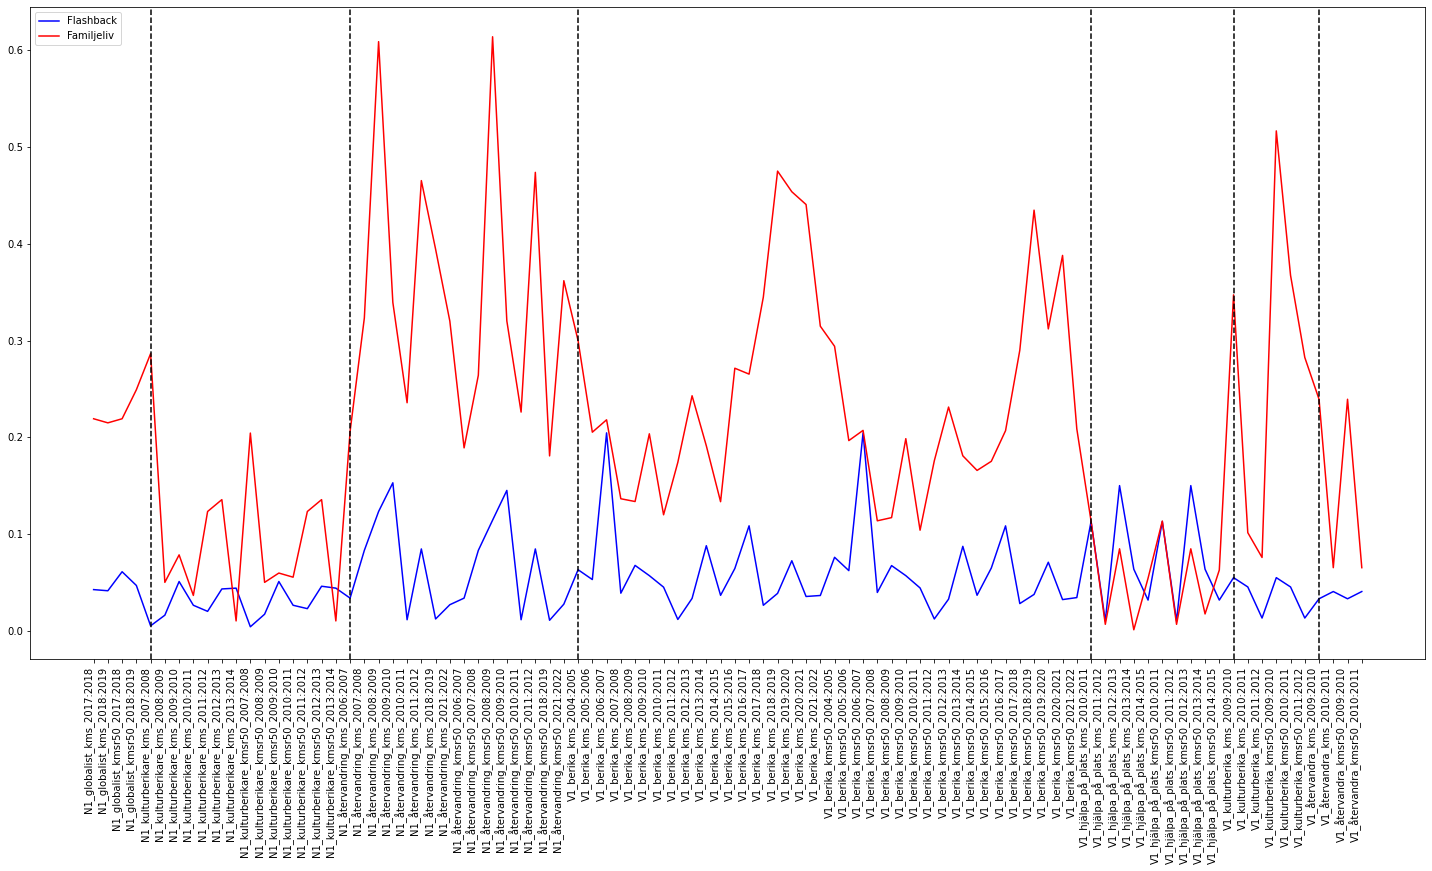

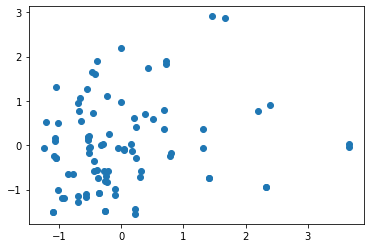

KMS_10


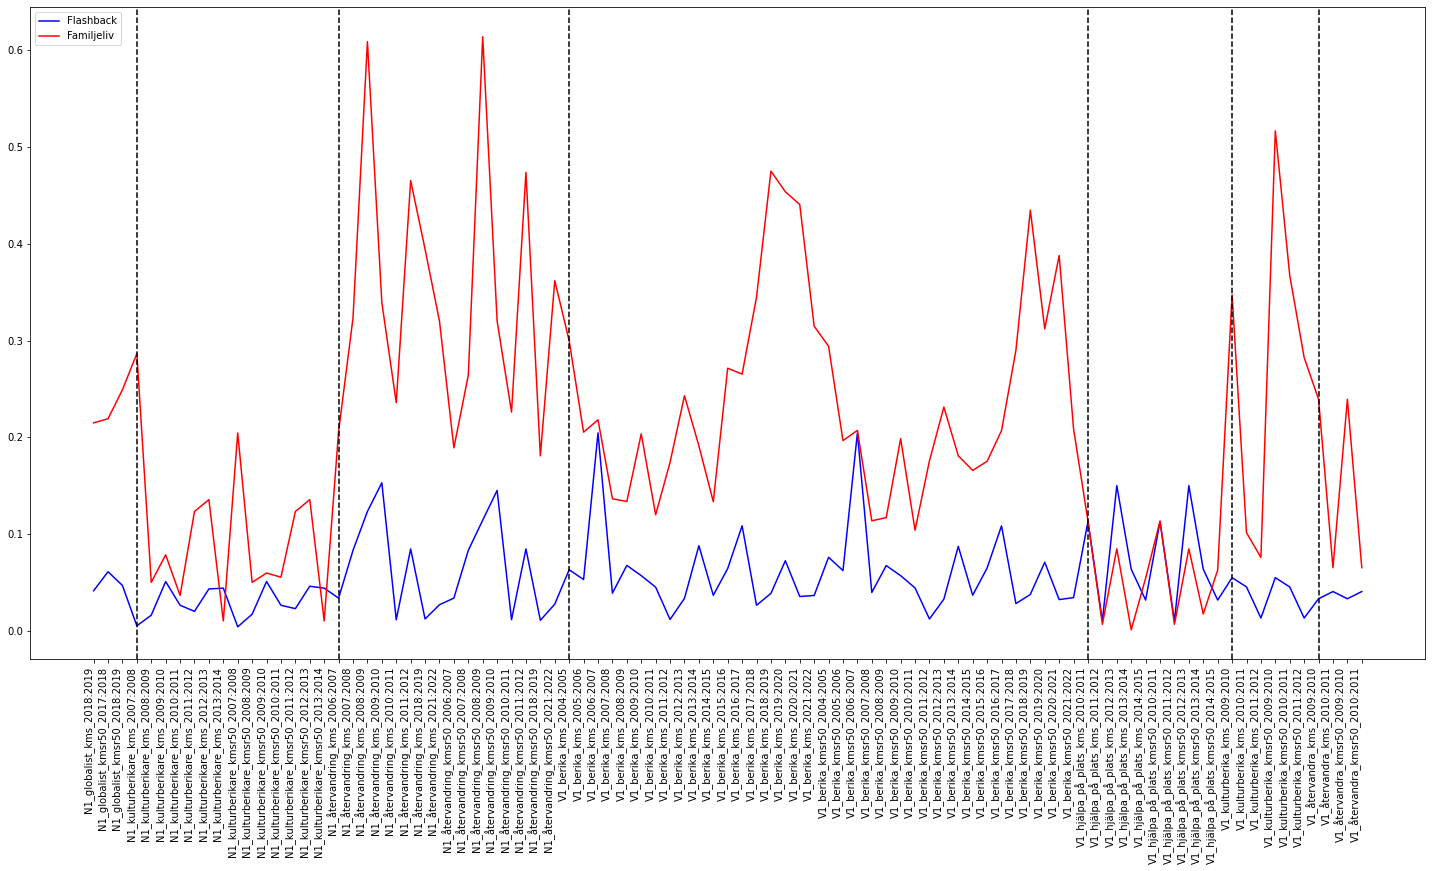

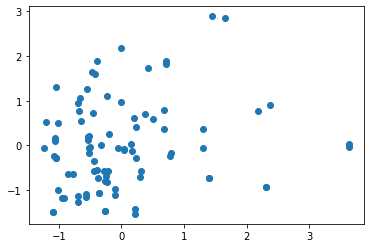

KMSR50_5


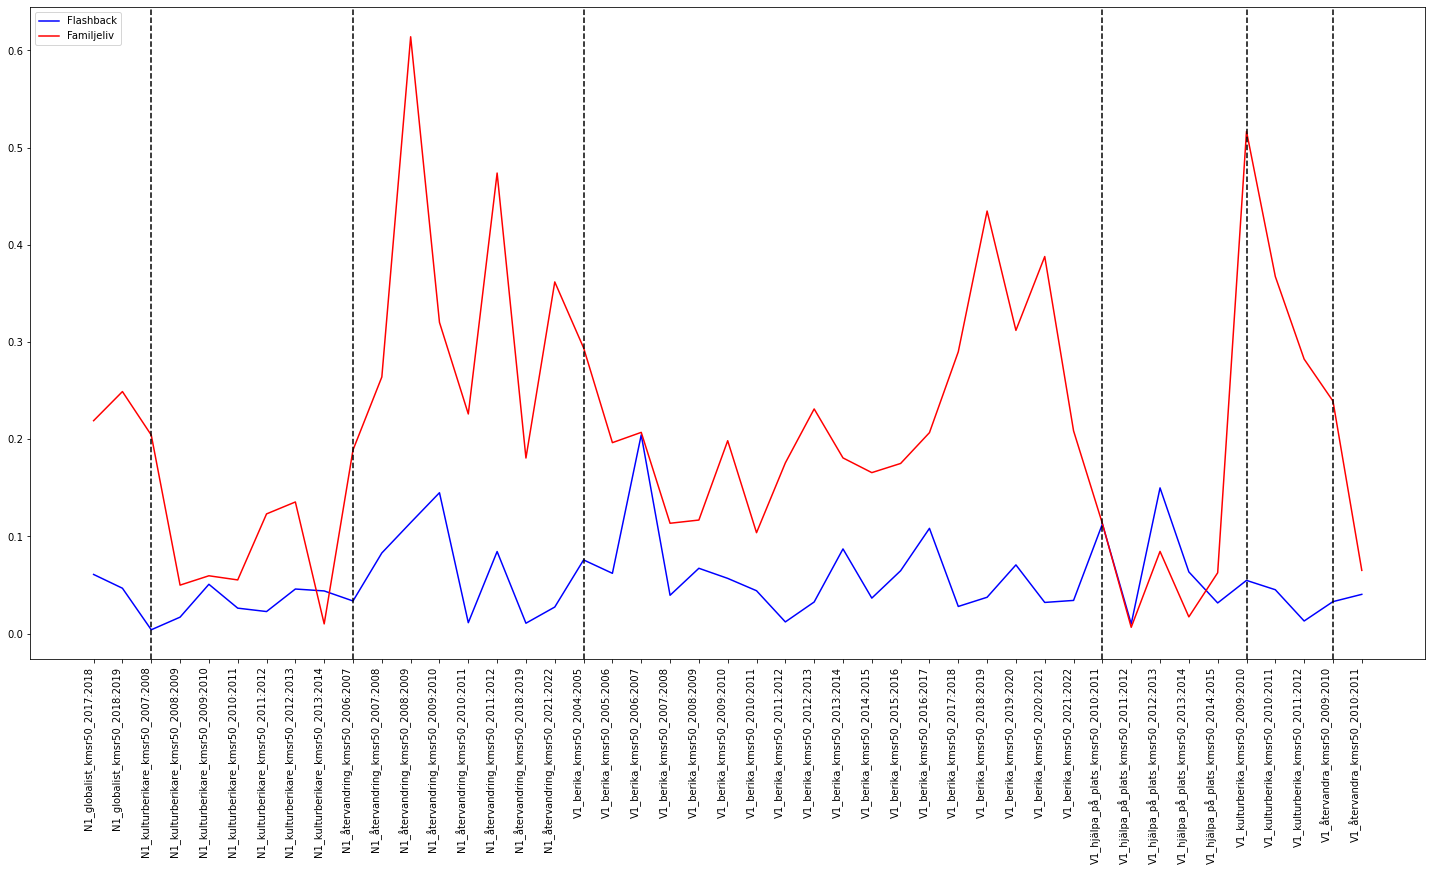

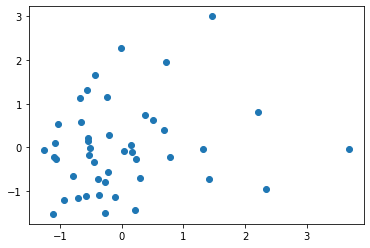

KMSR50_10


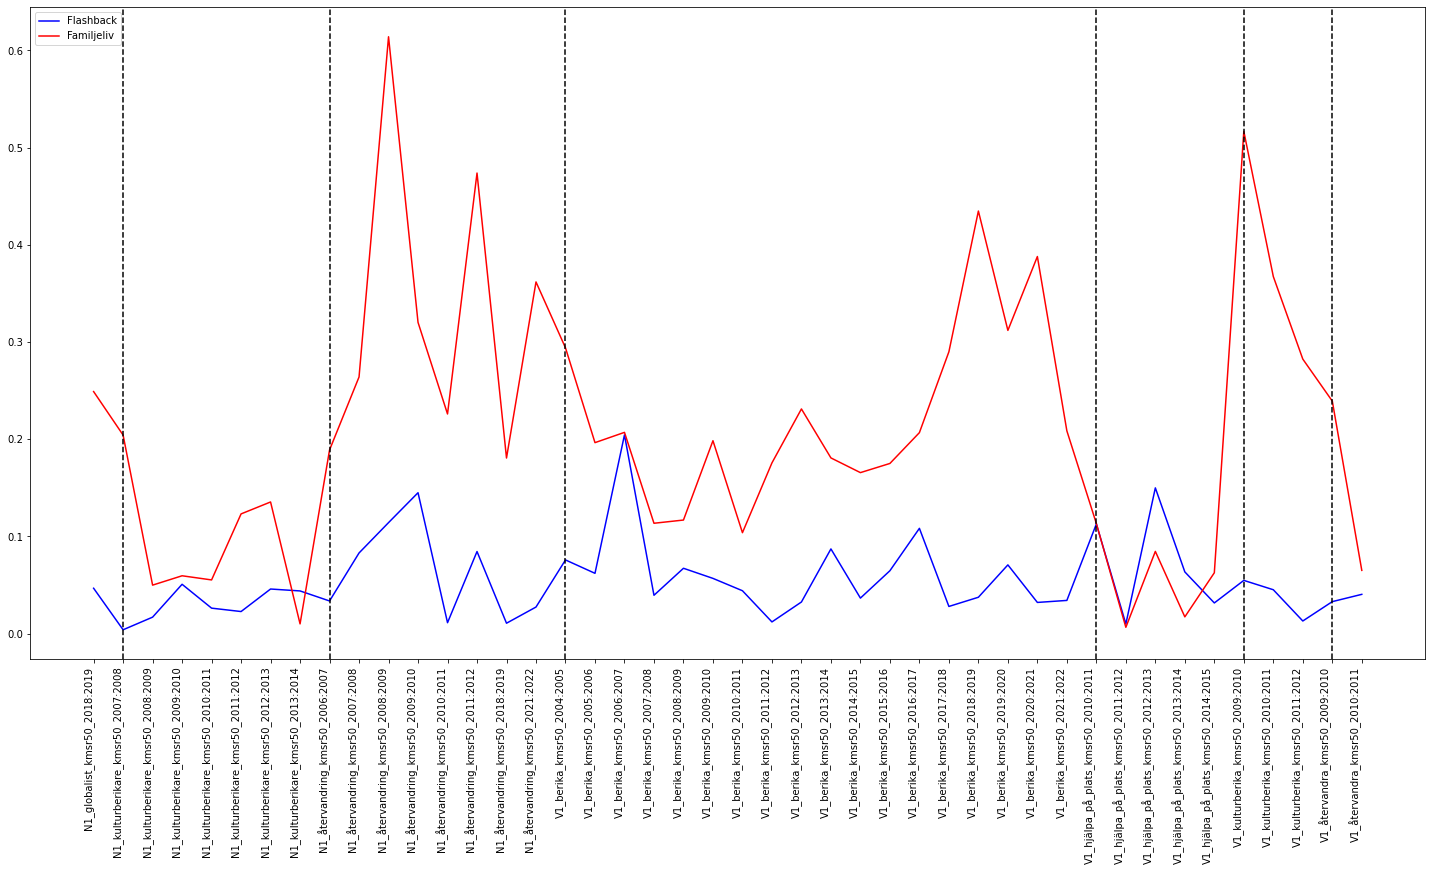

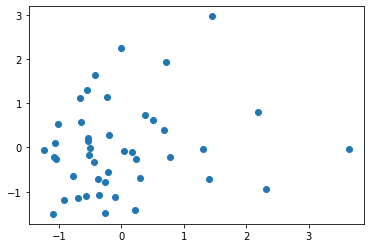

KM15_30


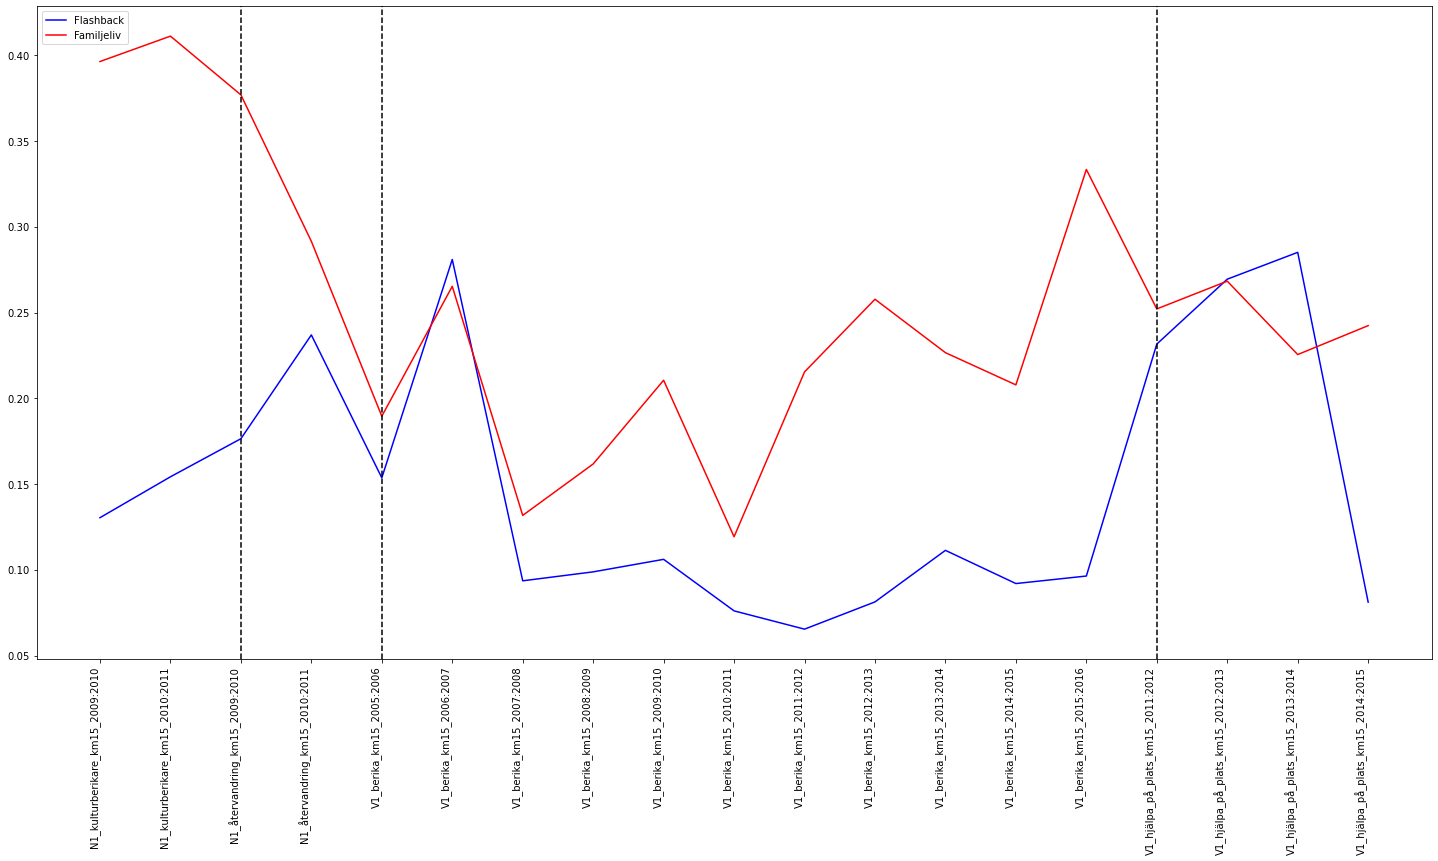

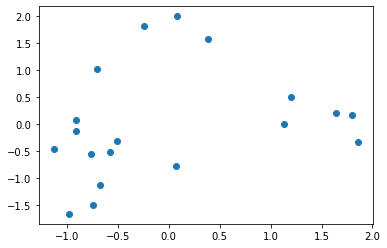

In [55]:
for name, A, B, ref in dist:
    print(name.upper())
    vis(A, B, ref)
    plt.scatter(zscore(A), zscore(B))
    plt.show()